Kawasaki Quantum Summer Camp 2024

# 量子ハードウェア：解答例


Kifumi Numata, IBM Quantum (Jul 31, 2024)

Google Colab で行う場合は、次のセルの「#」を削除して実行します。

In [ ]:
#!pip install qiskit qiskit-ibm-runtime qiskit-aer qiskit[visualization]

qBraid で行う場合は、右上の「Python 3[Default]」をクリックして「Python 3[QDC24]」を選択し、次のセルの「#」を削除して実行したあと、上部の「Kernel」→「Restart Kernel...」からカーネルをリスタートしてください。

In [ ]:
#!pip install pylatexenc
#!sudo apt install graphviz --yes
#!pip install seaborn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx
import statistics

from qiskit_ibm_runtime import QiskitRuntimeService

### バックエンドの情報をみる

Qiskitは、量子デバイスに関する情報を取得するためのAPI ([アプリケーション・プログラミング・インタフェース](https://ja.wikipedia.org/wiki/%E3%82%A2%E3%83%97%E3%83%AA%E3%82%B1%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E3%82%A4%E3%83%B3%E3%82%BF%E3%83%95%E3%82%A7%E3%83%BC%E3%82%B9))を提供しています。デバイスとのインターフェースである、Backend命令を使用を使って、IBM Quantum Platformの[デバイスカード](https://quantum.ibm.com/services/resources)に表示される情報の一部を取得してみましょう。以下では、"ibm_kyiv" を選びます。

In [2]:
# Google Colab で行う場合は、次の「#」を削除して、https://quantum.ibm.com/ の API Tokenをコピペして、実行します。
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='<IBM Quantum API key>')

service = QiskitRuntimeService()
backend = service.backend("ibm_kyiv")

まず、デバイスに関する基本的な情報から見てみます。

In [3]:
print(
    f"""
{backend.name}, {backend.num_qubits} qubits
processor type = {backend.processor_type} 
basis gates = {backend.basis_gates}
""")


ibm_kyiv, 127 qubits
processor type = {'family': 'Eagle', 'revision': 3} 
basis gates = ['ecr', 'id', 'rz', 'sx', 'x']



#### 演習 1

別のデバイス "ibm_sherbrooke" の基本情報を取得してみてください。

In [4]:
an_eagle = service.backend("ibm_sherbrooke") 

# ここにコードを入れます
print(
    f"""
{an_eagle.name}, {an_eagle.num_qubits} qubits
processor type = {an_eagle.processor_type} 
basis gates = {an_eagle.basis_gates}
""")


ibm_sherbrooke, 127 qubits
processor type = {'family': 'Eagle', 'revision': 3} 
basis gates = ['ecr', 'id', 'rz', 'sx', 'x']



### カップリング・マップ

次にデバイスのカップリング・マップを表示します。ご覧のように、ノード（頂点）が量子ビットで、番号が振られています。エッジ（辺）は、2量子ビットのエンタングルゲートが直接適用できるペアを示しています。このトポロジーはヘビーヘックス格子と呼ばれます。


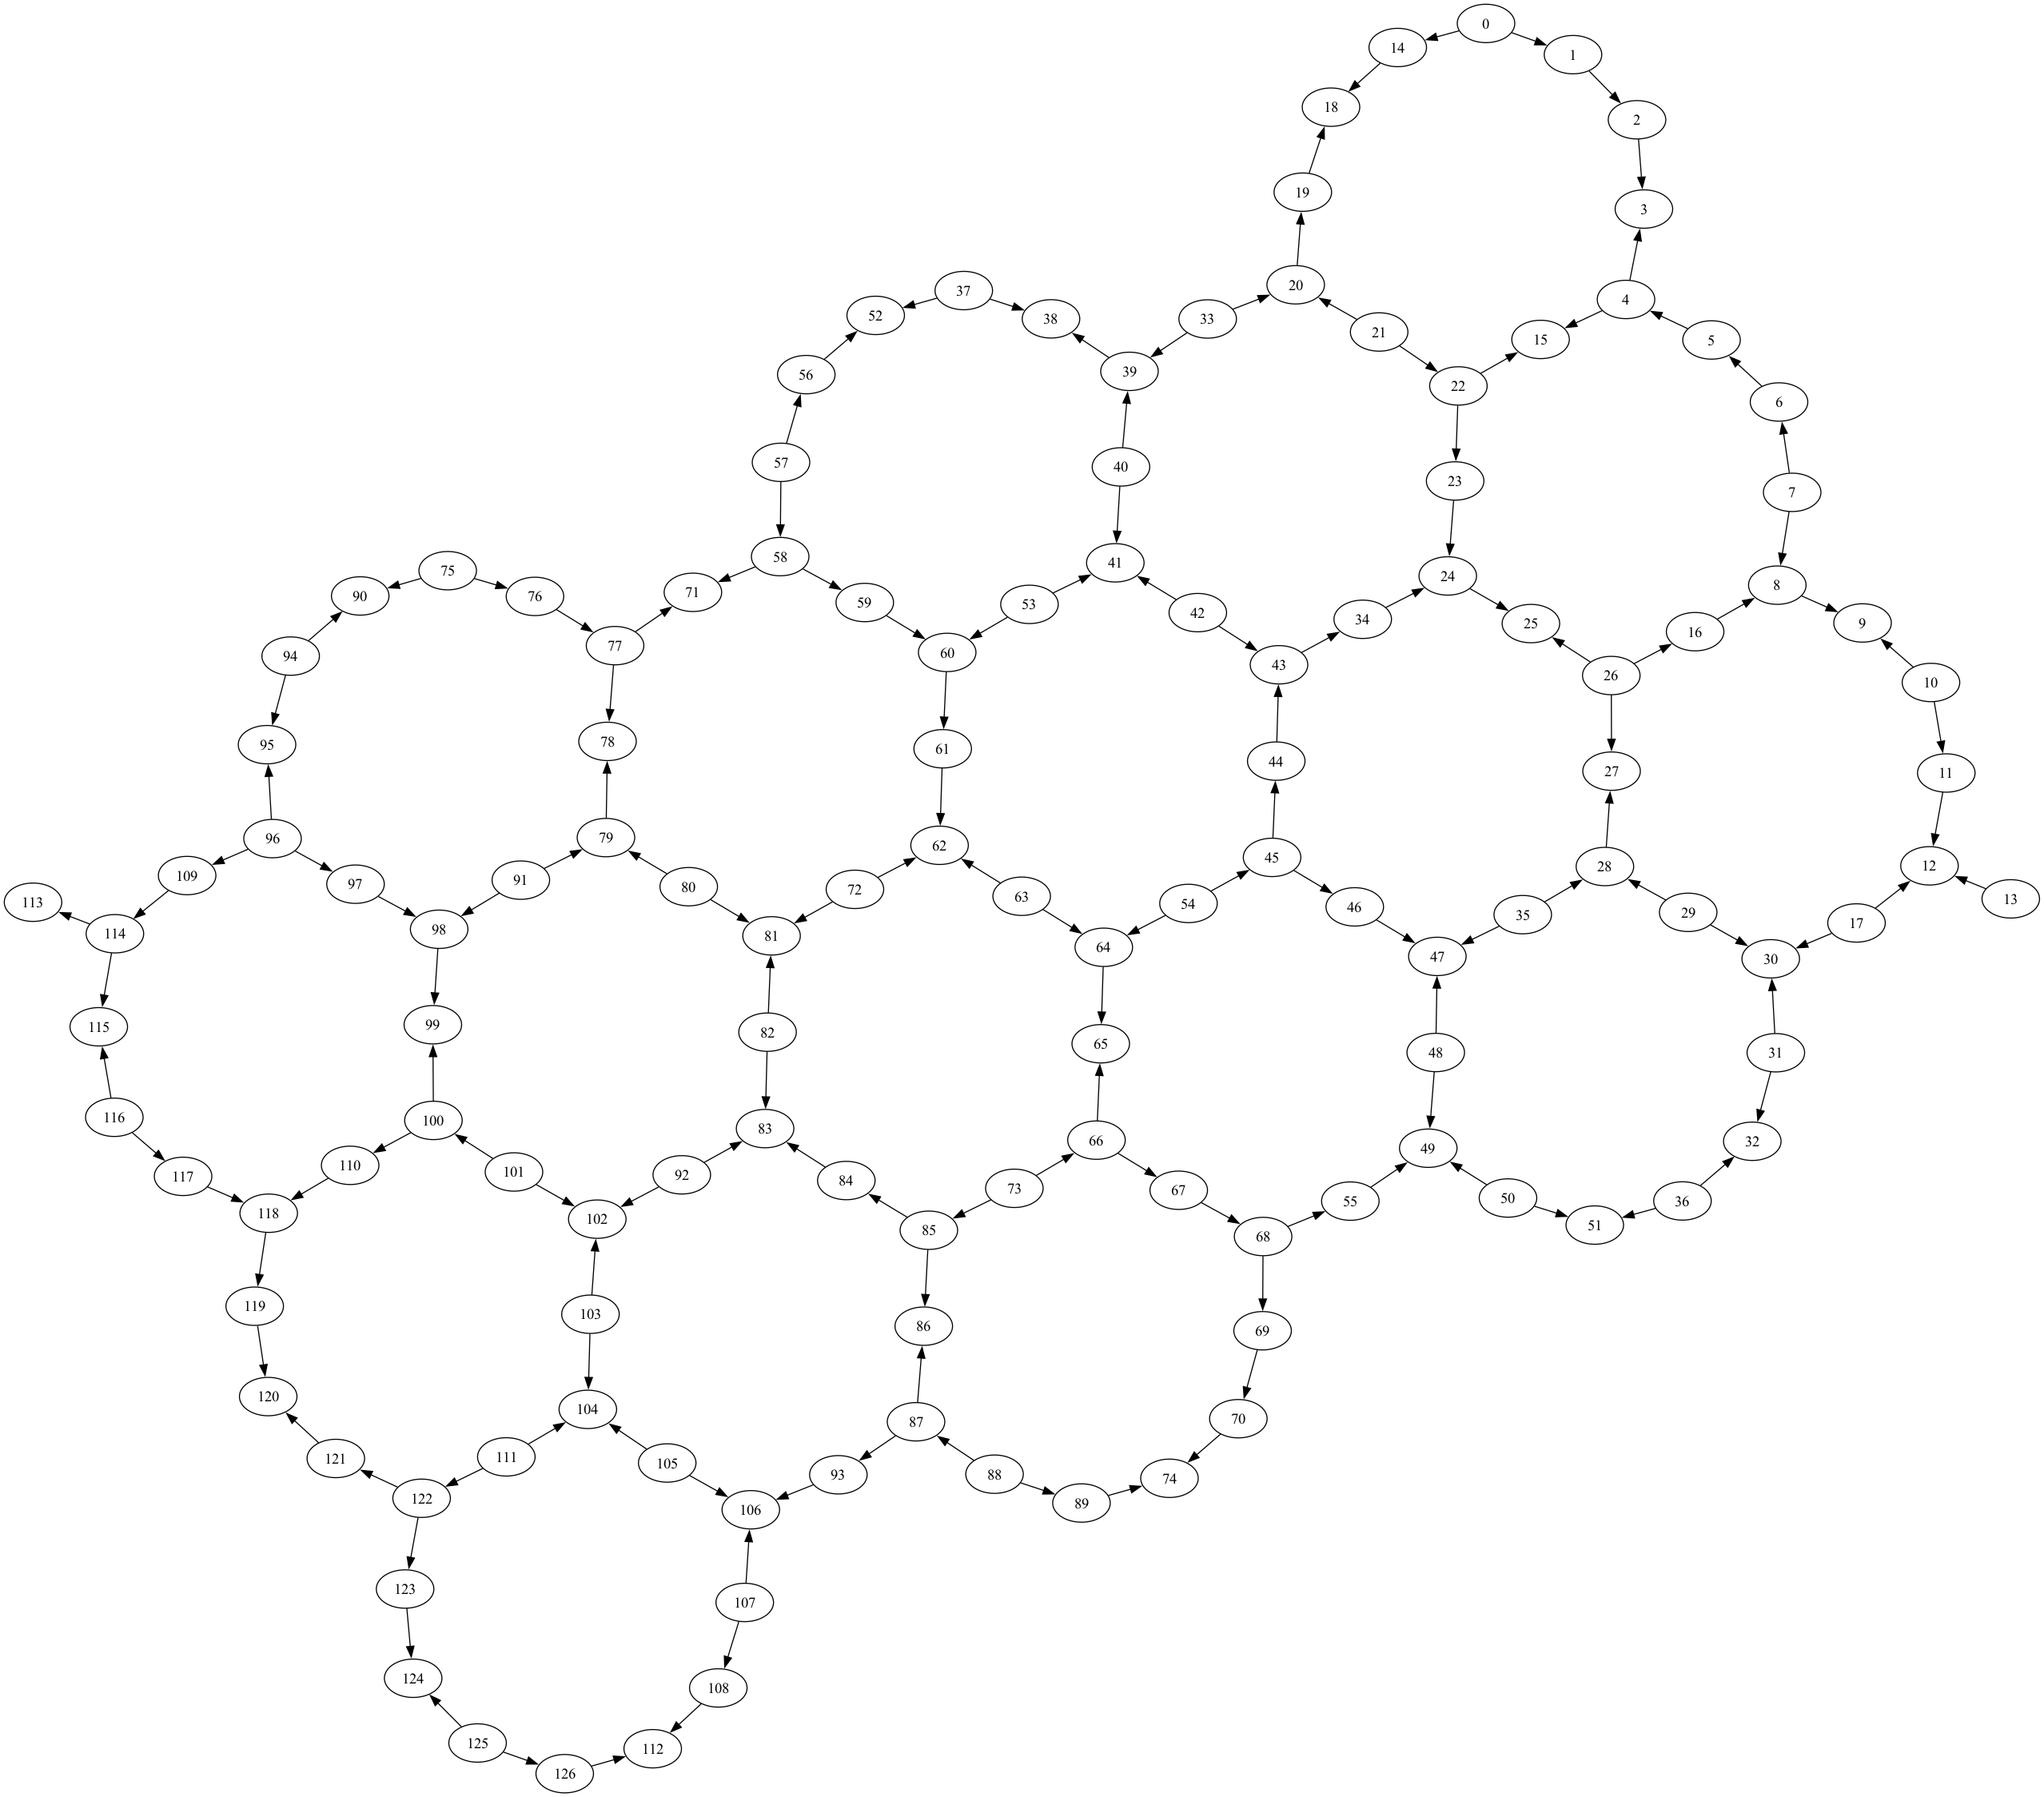

In [5]:
backend.coupling_map.draw()

### 量子ビットの特性

Eagle デバイスには127個の量子ビットがあります。そのいくつかの特性(Properties)を`qubit_properties`を使って、求めてみましょう。0~4までの5量子ビットのみ表示します。

In [6]:
for qn in range(backend.num_qubits):
    if (qn>=5):
        break
    print(f"{qn}: {backend.qubit_properties(qn)}")

0: QubitProperties(t1=0.00032221704436993185, t2=0.00035759468801414693, frequency=4655634653.539375)
1: QubitProperties(t1=0.00029107113622948836, t2=0.00011381457558584155, frequency=4534965471.7570915)
2: QubitProperties(t1=0.0002918006872544094, t2=0.00011859145454803986, frequency=4680130591.652006)
3: QubitProperties(t1=0.0004279195614098303, t2=0.0001421346822832623, frequency=4606645379.383141)
4: QubitProperties(t1=9.218575506367811e-05, t2=0.00015166241328590818, frequency=4462302230.655757)


各量子ビットごとのT1時間、T2時間、共鳴周波数が確認できました。    
量子ビットのT1時間の[中央値](https://ja.wikipedia.org/wiki/%E4%B8%AD%E5%A4%AE%E5%80%A4) (Median)を計算してみましょう。[IBM Quantum Platfrom](https://quantum.ibm.com/services/resources)のデバイスの結果と比較してみてください。

In [7]:
t1s = [backend.qubit_properties(qq).t1 for qq in range(backend.num_qubits)] #t1をリスト化
t1_m = statistics.median(t1s)*10**6 #中央値を求め、10の６乗をかけて単位をμsに。

print(f'Median T1: {t1_m:.2f}μs') #有効数字小数点以下２桁

Median T1: 285.81μs


#### 演習 2

量子ビットのT2時間の中央値を計算してください。

In [8]:
t2s = [backend.qubit_properties(qq).t2 for qq in range(backend.num_qubits)] #t2をリスト化
t2_m = statistics.median(t2s)*10**6 #中央値を求め、10の６乗をかけて単位をμsに。

print(f'Median T2: {t2_m:.2f}μs') #有効数字小数点以下２桁

Median T2: 117.28μs


###  ゲートエラーと読み出しエラー

次にゲートエラーについて見てみます。まずはじめに、backendのtargetのデータ構造を調べます。演算の名前をキーとする[辞書](https://utokyo-ipp.github.io/3/3-1.html)になっています。

In [9]:
target = backend.target
target.keys()

dict_keys(['if_else', 'measure', 'x', 'sx', 'id', 'ecr', 'rz', 'delay', 'switch_case', 'for_loop', 'reset'])

その値も辞書です。'sx' 演算の値（辞書）の項目を5個目まで見てみましょう。

In [10]:
for i, qq in enumerate(target['sx']):
    if (i>=5):
        break
    print(i, qq, target['sx'][qq])

0 (0,) InstructionProperties(duration=4.977777777777777e-08, error=0.0001277978382359072, calibration=PulseQobj)
1 (1,) InstructionProperties(duration=4.977777777777777e-08, error=0.000515704442005023, calibration=PulseQobj)
2 (2,) InstructionProperties(duration=4.977777777777777e-08, error=0.000223994664346982, calibration=PulseQobj)
3 (3,) InstructionProperties(duration=4.977777777777777e-08, error=0.000175786587116596, calibration=PulseQobj)
4 (4,) InstructionProperties(duration=4.977777777777777e-08, error=0.0006554336872070271, calibration=PulseQobj)


演算の持続時間(duration)、エラー率、キャリブレーションの形式をみることができました。

'ecr' 演算と 'measure' 演算についても同じようにみてみましょう。

In [11]:
for i, edge in enumerate(target['ecr']):
    if (i>=5):
        break
    print(i, edge, target['ecr'][edge])

0 (0, 1) InstructionProperties(duration=5.617777777777778e-07, error=0.012766258444254996, calibration=PulseQobj)
1 (0, 14) InstructionProperties(duration=5.617777777777778e-07, error=0.005050500443623207, calibration=PulseQobj)
2 (1, 2) InstructionProperties(duration=5.617777777777778e-07, error=0.009543647693689039, calibration=PulseQobj)
3 (2, 3) InstructionProperties(duration=5.617777777777778e-07, error=0.004362311264798913, calibration=PulseQobj)
4 (4, 3) InstructionProperties(duration=5.617777777777778e-07, error=0.012640780487982284, calibration=PulseQobj)


In [12]:
for i, qq in enumerate(target['measure']):
    if (i>=5):
        break
    print(i, qq, target['measure'][qq])

0 (0,) InstructionProperties(duration=1.2444444444444443e-06, error=0.002197265625, calibration=PulseQobj)
1 (1,) InstructionProperties(duration=1.2444444444444443e-06, error=0.005859375, calibration=PulseQobj)
2 (2,) InstructionProperties(duration=1.2444444444444443e-06, error=0.001708984375, calibration=PulseQobj)
3 (3,) InstructionProperties(duration=1.2444444444444443e-06, error=0.005615234375, calibration=PulseQobj)
4 (4,) InstructionProperties(duration=1.2444444444444443e-06, error=0.063232421875, calibration=PulseQobj)


それそれの error の値から、読み出し(measure)エラーは2量子ビット演算(ecr)のエラーよりも大きくなる傾向があり、2量子ビット演算(ecr)のエラーは、1量子ビット演算(sx)のエラーよりも大きくなる傾向があることが分かります。

データ構造を理解したところで、'sx' ゲートと 'ecr' ゲートのエラーの中央値を計算しましょう。ここでも、[IBM Quantum Platfrom](https://quantum.ibm.com/services/resources) のデバイスで示された結果と比較してください。

In [13]:
sx_errors = [inst_prop.error for inst_prop in target['sx'].values()] #リスト化
sx_errors_m = statistics.median(sx_errors) #中央値を計算

print(f'Median SX error: {sx_errors_m:.3e}μs') #有効数字 小数点以下指数表示で3桁

Median SX error: 2.504e-04μs


In [14]:
ecr_errors = [inst_prop.error for inst_prop in target['ecr'].values()] #リスト化
ecr_errors_m = statistics.median(ecr_errors) #中央値を計算

print(f'Median ECR error: {ecr_errors_m:.3e}μs') #有効数字 小数点以下指数表示で3桁

Median ECR error: 1.156e-02μs


#### 演習 3

デバイスの読み出しエラーの中央値を計算してください。

In [15]:
# コードをここに書いてください
meas_errors = [inst_prop.error for inst_prop in target['measure'].values()] #リスト化
meas_errors_m = statistics.median(meas_errors) #中央値を計算

print(f'Median readout error: {meas_errors_m:.3e}') #有効数字 小数点以下指数表示で3桁

Median readout error: 1.221e-02


### パルス形状
次に、InstructionPropertiesのcalibration（較正）の属性を見てみましょう。実は、命令のパルス形状を得ることができます。Qubit 0の 'sx' 命令をチェックしてみましょう。


/var/folders/z_/wh262lbd0y3525732h4t_4d00000gn/T/ipykernel_45699/2245713552.py:1: DeprecationWarning: The property ``qiskit.transpiler.target.InstructionProperties.calibration`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.transpiler.target.InstructionProperties.calibration`` will have no alternative in Qiskit.
  print(backend.target["sx"][(0, )].calibration)


Schedule((0, Play(Drag(duration=224, sigma=56, beta=2.546793214297093, amp=0.0725749173576416, angle=-0.002230266886023316, name='X90p_d0'), DriveChannel(0), name='X90p_d0')), name="sx")


/var/folders/z_/wh262lbd0y3525732h4t_4d00000gn/T/ipykernel_45699/2245713552.py:2: DeprecationWarning: The property ``qiskit.transpiler.target.InstructionProperties.calibration`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.transpiler.target.InstructionProperties.calibration`` will have no alternative in Qiskit.
  backend.target["sx"][(0, )].calibration.draw()


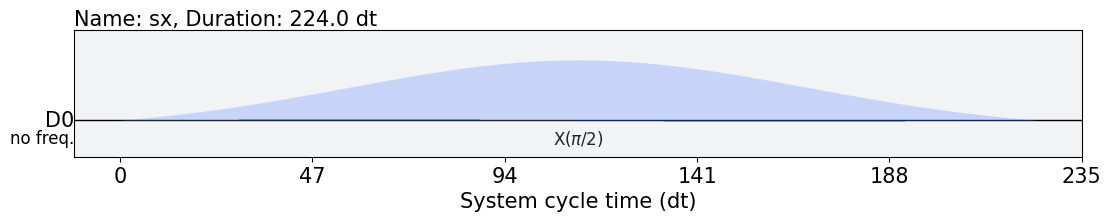

In [16]:
print(backend.target["sx"][(0, )].calibration)
backend.target["sx"][(0, )].calibration.draw()

ここでみてきたことがらは、BackendとTargetでできることのほんの一例に過ぎません。

さらに、[Qiskit Experiment](https://qiskit-extensions.github.io/qiskit-experiments/) を使えば、Qiskitを通して特性評価やキャリブレーション実験を行うことができますが、今回は扱いません。

## 付録 

Qiskit は、可視化機能が充実していることでも人気があります。回路の可視化、状態や分布の可視化、ターゲットデバイスの可視化ができます。回路の可視化、状態や分布の可視化は、このノートブックですでに使ってみたので、ターゲットデバイスの可視化の機能を以下で使ってみましょう。

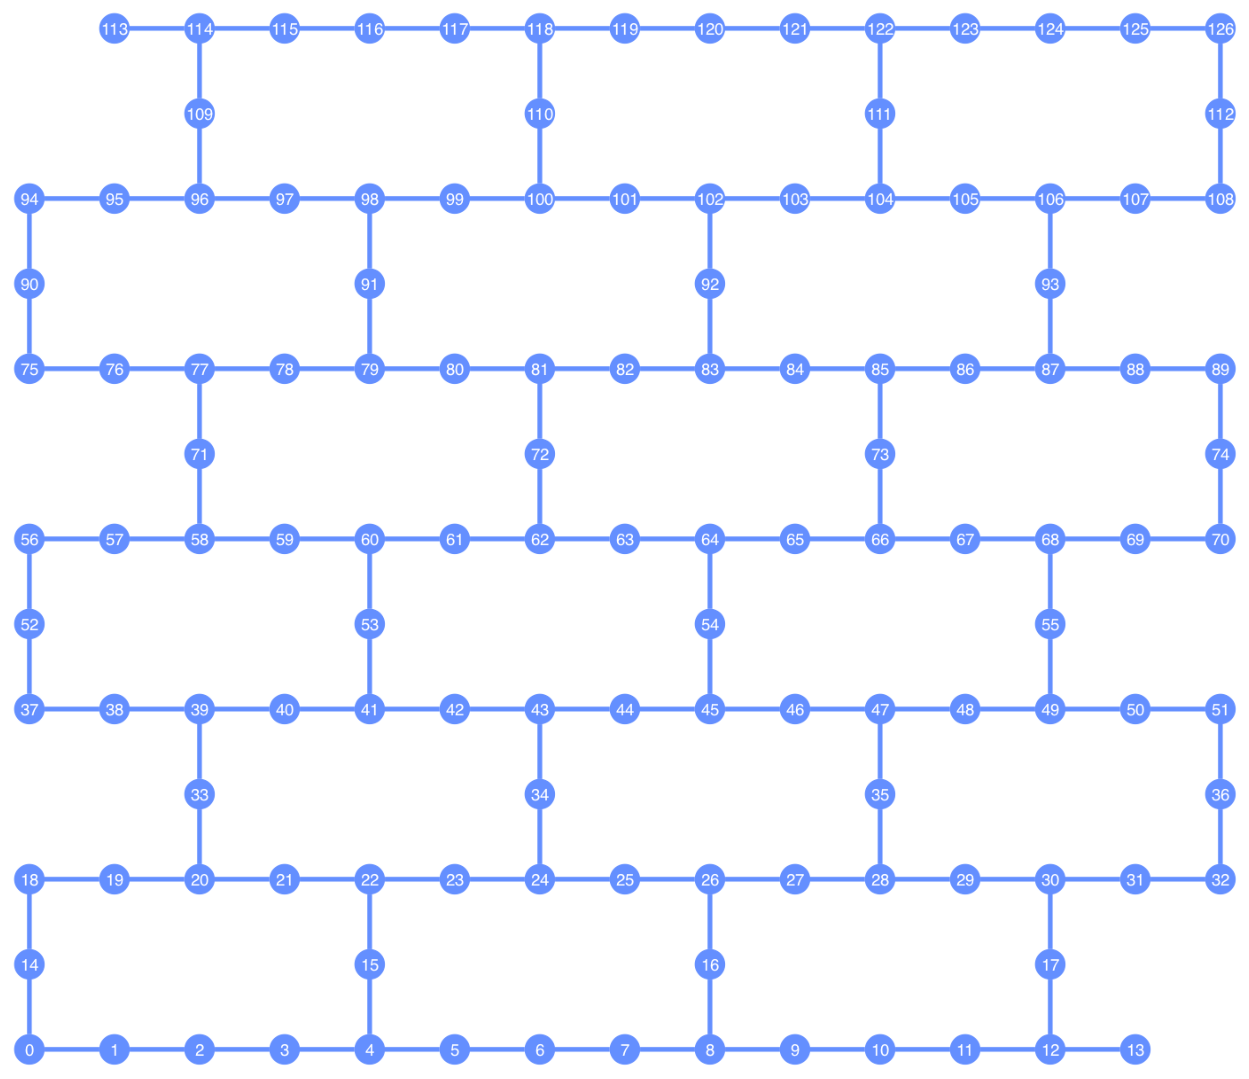

In [17]:
from qiskit.visualization import plot_gate_map

plot_gate_map(backend, font_size=14)

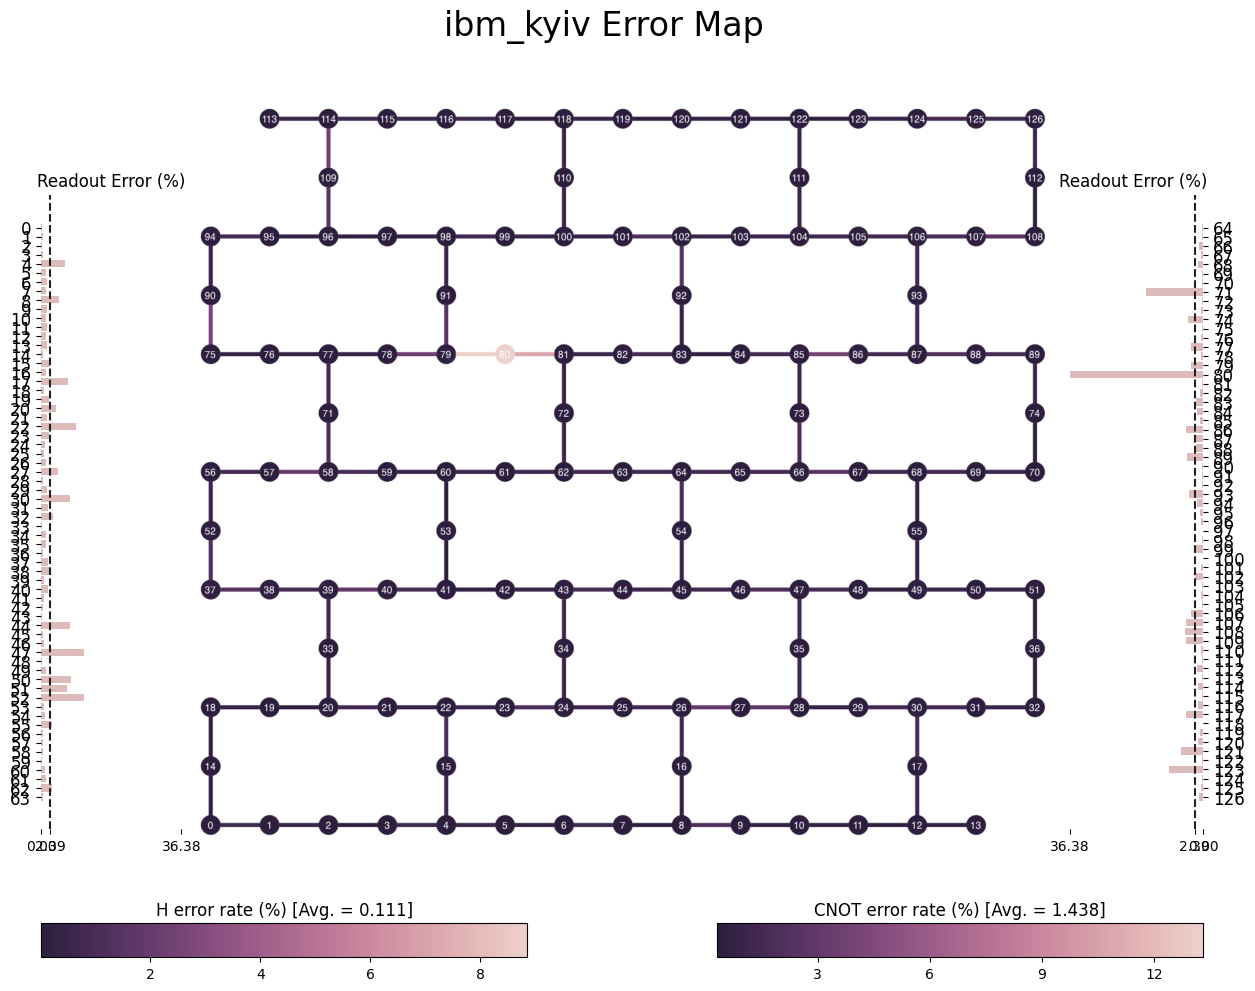

In [18]:
from qiskit.visualization import plot_error_map

plot_error_map(backend)

In [19]:
import qiskit
qiskit.__version__

'1.3.2'